In [1]:
import torch
from torch import nn, optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import urllib
import urllib.request

device = torch.device("cpu")

In [2]:
class Config:
    external_data_size = 10000
    train_size = 8000
    image_size_1 = 256
    image_size_2 = 256
    batch_size = 32
    LeakyReLU_slope = 0.2
    dropout = 0.5
    kernel_size = 4
    stride = 2
    padding = 1
    gen_lr = 2e-4
    disc_lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999
    lambda_l1 = 100
    gan_mode = 'vanilla'
    layers_to_cut = -2
    epochs = 10
    pretrain_lr = 1e-4

In [3]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [4]:
class Discriminator(nn.Module):
    '''
    
    The Discriminator Model Class
    
    '''
    
    def __init__(self,input_channels,num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_channels,num_filters,norm = False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), stride=1 if i == (n_down-1) else 2) for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, stride=1, norm=False, activation=False)] 
        self.model = nn.Sequential(*model)
    
    def get_layers(self, ni, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, norm=True, activation=True): 
        layers = [nn.Conv2d(ni, nf, kernel_size, stride, padding, bias=not norm)]          
        if norm: 
            layers += [nn.BatchNorm2d(nf)]
        if activation:
            layers += [nn.LeakyReLU(Config.LeakyReLU_slope, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class GANLoss(nn.Module):
    '''
    
    Class that defines the GAN loss.
    
    '''
    
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [6]:
class UnetBlock(nn.Module):
    '''
    
    Class that helps define the various different types of blocks used in the Generator architecture
    
    '''
    
    def __init__(self, nf, ni, submodule=None, input_channels=None, dropout=False,innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_channels is None: 
            input_channels = nf
        downconv = nn.Conv2d(input_channels, ni, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
        downrelu = nn.LeakyReLU(Config.LeakyReLU_slope, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf,kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(Config.dropout)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)
            
class Unet(nn.Module):
    '''
    
    The Generator Model Class
    
    '''
    
    def __init__(self, input_channels=1, output_channels=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_channels, out_filters, input_channels=input_channels, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [18]:
class MainModel(nn.Module):
    '''
    
    The Class where it all comes together.
    
    '''
    
    def __init__(self,generator = None,gen_lr =Config.gen_lr,disc_lr = Config.disc_lr, beta1 = Config.beta1,beta2 = Config.beta2, lambda_l1 = Config.lambda_l1):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_l1 = lambda_l1
        
        if generator is None:
            self.generator = init_model(Unet(input_channels=1, output_channels=2, n_down=8, num_filters=64),self.device)
        else:
            self.generator = generator.to(self.device)
        self.discriminator = init_model(Discriminator(input_channels = 3,num_filters = 64,n_down = 3),self.device)
        self.GANloss = GANLoss(gan_mode=Config.gan_mode).to(self.device)
        self.L1loss = nn.L1Loss()
        self.gen_optim = optim.Adam(self.generator.parameters(), lr=gen_lr, betas=(beta1, beta2))
        self.disc_optim= optim.Adam(self.discriminator.parameters(), lr=disc_lr, betas=(beta1, beta2))
        
    def requires_grad(self,model,requires_grad = True):
        for p in model.parameters():
            p.requires_grad = requires_grad
            
    def prepare_input(self,data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.gen_output = self.generator(self.L)
        
    def disc_backward(self):
        gen_image = torch.cat([self.L, self.gen_output], dim=1)
        gen_image_preds = self.discriminator(gen_image.detach())
        self.disc_loss_gen = self.GANloss(gen_image_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.discriminator(real_image)
        self.disc_loss_real = self.GANloss(real_preds, True)
        self.disc_loss = (self.disc_loss_gen + self.disc_loss_real) * 0.5
        self.disc_loss.backward()
    
    def gen_backward(self):
        gen_image = torch.cat([self.L, self.gen_output], dim=1)
        gen_image_preds = self.discriminator(gen_image)
        self.loss_G_GAN = self.GANloss(gen_image_preds, True)
        self.loss_G_L1 = self.L1loss(self.gen_output, self.ab) * self.lambda_l1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.discriminator.train()
        self.requires_grad(self.discriminator, True)
        self.disc_optim.zero_grad()
        self.disc_backward()
        self.disc_optim.step()
        
        self.generator.train()
        self.requires_grad(self.discriminator, False) 
        self.gen_optim.zero_grad()
        self.gen_backward()
        self.gen_optim.step()

In [23]:
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from torchvision.models.resnet import resnet18
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

In [12]:
def build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1):
    '''
    
    Function that helps build the generator backbone using another pretrained model trained on imagenet for image classification
    
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=input_channels, cut=Config.layers_to_cut)
    generator = DynamicUnet(body, output_channels, (size, size)).to(device)
    return generator

In [19]:
gen = build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1)

gen.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(generator=gen)



model initialized with norm initialization


In [24]:
def lab_to_rgb(L, ab):
    """
    
    Takes a batch of images and converts from LAB space to RGB
    
    """
    
    L = (L + 1.) * 50
    ab = ab * 128
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [26]:
image = Image.open("cache/102685.jpg")

    

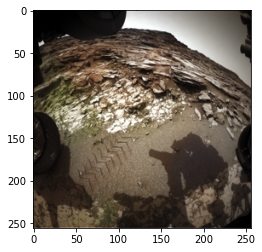

In [27]:
img = Image.fromarray(np.uint8(image)).convert("RGB")
img = img.resize((256, 256))
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()
with torch.no_grad():
    preds = model.generator(img.unsqueeze(0).to(device))
    gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
# plt.imshow(img)
plt.imshow(gen_output)

In [ ]:
patches = x.unfold(3, kernel_size, stride).unfold(2, kernel_size, stride)
becomes
patches = x.unfold(3, kernel_size, stride).unfold(2, kernel_size, stride).permute(0,1,2,3,5,4)

In [ ]:
img_rszd = tf.image.resize(
    image,
    [224,224]
)

In [ ]:
img_rszd.numpy()


In [ ]:
res = new_model.predict(np.expand_dims(img_rszd, axis=0))

In [ ]:
PIL_image = Image.fromarray(np.uint8(res[0])).convert('RGB')
PIL_image.show()

In [ ]:
img_ori = Image.fromarray(np.uint8(img_rszd)).convert('RGB')
img_ori.show()

In [ ]:
base_url = "https://api.nasa.gov/mars-photos/api/v1/rovers/curiosity/photos?sol="+str(sol)+"&camera=fhaz&api_key="

In [28]:
image = Image.open("cache/102685.jpg")
img = Image.fromarray(np.uint8(image)).convert("RGB")
# img = img.resize((256, 256))
# img = transforms.ToTensor()(img)[:1] * 2. - 1.
# model.eval()
# with torch.no_grad():
#     preds = model.generator(img.unsqueeze(0).to(device))
#     gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
# # plt.imshow(img)
# plt.imshow(gen_output)

In [31]:
img = transforms.ToTensor()(img)[:1] * 2. - 1.

In [33]:
img.shape


torch.Size([1, 1024, 1024])

In [42]:
patches = img.unfold(1, 256, 256).unfold(2, 256, 256)

In [ ]:
gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
# # plt.imshow(img)
# plt.imshow(gen_output)

In [43]:
patches.shape

torch.Size([1, 4, 4, 256, 256])

In [46]:
patches = patches * -1

In [47]:
patches

tensor([[[[[ 0.8431,  0.8431,  0.8431,  ...,  0.6941,  0.7020,  0.7255],
           [ 1.0000,  1.0000,  1.0000,  ...,  0.9451,  0.9294,  0.9294],
           [ 0.9922,  1.0000,  1.0000,  ...,  0.9843,  0.9529,  0.9373],
           ...,
           [ 0.9608,  0.9608,  0.9608,  ...,  0.7804,  0.8275,  0.8196],
           [ 0.9765,  0.9765,  0.9843,  ...,  0.8039,  0.7804,  0.7490],
           [ 0.9765,  0.9843,  0.9922,  ...,  0.7490,  0.6471,  0.6157]],

          [[ 0.7647,  0.7569,  0.7412,  ..., -0.9922, -0.9922, -0.9922],
           [ 0.9608,  0.9686,  0.9686,  ..., -0.7882, -0.7647, -0.7490],
           [ 0.9451,  0.9529,  0.9765,  ..., -0.6157, -0.5922, -0.6471],
           ...,
           [ 0.7647,  0.7412,  0.7490,  ..., -0.3961, -0.4510, -0.3647],
           [ 0.6784,  0.7176,  0.8039,  ..., -0.5451, -0.5137, -0.4588],
           [ 0.6941,  0.7804,  0.8588,  ..., -0.7255, -0.7098, -0.6000]],

          [[-0.9922, -1.0000, -0.9922,  ..., -1.0000, -0.9843, -1.0000],
           [-0.